In [1]:
from pandas import read_csv, DataFrame, concat
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed
from keras.optimizers import Adam
from keras.constraints import nonneg
from matplotlib import pyplot
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import model_from_json
from os.path import isfile
import numpy as np 
import sys
import random
import os
from keras.losses import logcosh

Using TensorFlow backend.


In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
def getXY(filename, scale):

    dataset = read_csv(filename, header=0, index_col=0)
    dataset[["Searches"]] /= 100
    dataset[["Cases"]] = dataset[["Cases"]].apply(lambda x: x*100000/scale, axis=1)


    values = dataset.values.astype("float32")
    total_features = len(values[0])

    n_weeks = 4
    n_features = 2

    reframed = series_to_supervised(values, n_weeks, 1)
    values = reframed.values
    print("Reframed Shape: ", reframed.shape)
    totalFeatures = reframed.shape[1]
    n_obs = n_weeks * n_features

    x, y = values[:, :-2], values[:, -1] # Pick last week's cases as y and drop last week's 

    x = x.reshape((x.shape[0], n_weeks, n_features)) # Reshape as 3-D
    return x, y

In [4]:
def saveModel(model, modelName):
    jsonName = "{}.json".format(modelName)
    h5Name = "{}.h5".format(modelName)

    model_json = model.to_json()
    with open(jsonName, "w") as json_file:
        json_file.write(model_json)
    #seralize weights to HDF5
    model.save_weights(h5Name)


In [6]:
def loadOrCreateModel(modelName): 

    jsonName = "{}.json".format(modelName)
    h5Name = "{}.h5".format(modelName)

    if(isfile(jsonName) and isfile(h5Name)):

        loaded_model_json = None
        with open(jsonName, "r") as json_file:
            loaded_model_json = json_file.read()

        model = model_from_json(loaded_model_json)
        model.load_weights(h5Name)
        model.compile(loss=[logcosh], optimizer="adam", metrics=["mse"])
        return model
    else:
        model = Sequential()
        model.add(LSTM(256, input_shape=(4, 2), return_sequences=True))
        model.add(LSTM(64, activation="relu", return_sequences=True))
        model.add(LSTM(32, activation="relu", return_sequences=False))

        model.add(Dense(128, activation="relu"))
        model.add(Dense(1, activation='linear', kernel_constraint=nonneg()))
        # model.add(Dense(1, activation="relu", kernel_constraint=nonneg()))
        model.compile(loss=[logcosh], optimizer="adam", metrics=["mse"])
        model.summary()
        return model

In [7]:
#Population values
population = {
    "Alagoas.csv": 3408510,
    "Bahia.csv": 15126371,
    "Ceara.csv": 8842791,
    "Goias.csv": 6523222,
    "Maranhao.csv": 6850884,
    "MatoGrosso.csv": 3224357,
    "MinasGerais.csv": 20734097,
    "Para.csv" : 8073924,
    "RioDeJaneiro.csv" : 16461173,
    "SaoPaulo.csv" : 44035304,
}

In [8]:
def ExportPredictions(model, folder, test_files):
    for file in test_files:
        outputName = "Predictions-{}".format(file)
        x, y = getXY("{}/{}".format(dataFolder, file), population[file])
        with open("{}/{}".format(folder, outputName), "w") as outputFile:
            outputFile.write("Value,Prediction,Error\n")
            predictions = model.predict(x)
            y = y.reshape((len(y), 1))
            inv_yPred = np.apply_along_axis(lambda x: x * population[file] / 100000, 1, predictions)
            inv_y = np.apply_along_axis(lambda x: x * population[file] / 100000, 1, y)
            for i in range(len(inv_yPred)):
                yPred = float(inv_yPred[i])
                yReal = float(inv_y[i])
                outputFile.write("{},{},{}\n".format(yReal, yPred, yPred-yReal))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 256)            265216    
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 64)             82176     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 364,161
Trainable params: 364,161
Non-trainable params: 0
_________________________________________________________________
Reframed Shape:  (45, 10)
Epoch 1/10
45/45 [==============================] - 4s 86ms/step - loss: 0.6151 - mean_squared_error: 2.0076
E

Epoch 5/10
45/45 [==============================] - 0s 1ms/step - loss: 0.0325 - mean_squared_error: 0.0668
Epoch 6/10
45/45 [==============================] - 0s 1ms/step - loss: 0.0322 - mean_squared_error: 0.0661
Epoch 7/10
45/45 [==============================] - 0s 956us/step - loss: 0.0318 - mean_squared_error: 0.0654
Epoch 8/10
45/45 [==============================] - 0s 933us/step - loss: 0.0314 - mean_squared_error: 0.0646
Epoch 9/10
45/45 [==============================] - 0s 1ms/step - loss: 0.0310 - mean_squared_error: 0.0638
Epoch 10/10
45/45 [==============================] - 0s 844us/step - loss: 0.0306 - mean_squared_error: 0.0630
Reframed Shape:  (45, 10)
Test RMSE: 194.665
Total [ 6398.00005007]
len 45
Reframed Shape:  (45, 10)
Reframed Shape:  (45, 10)
Reframed Shape:  (45, 10)
Reframed Shape:  (45, 10)
Test RMSE: 3902.299
Total [ 33663.99980286]
len 45
Reframed Shape:  (45, 10)
Reframed Shape:  (45, 10)
Reframed Shape:  (45, 10)
Reframed Shape:  (45, 10)
Test RMSE: 

Epoch 5/10
45/45 [==============================] - 0s 889us/step - loss: 1.9404 - mean_squared_error: 32.7093
Epoch 6/10
45/45 [==============================] - 0s 844us/step - loss: 1.8310 - mean_squared_error: 30.8247
Epoch 7/10
45/45 [==============================] - 0s 778us/step - loss: 1.7277 - mean_squared_error: 28.9510
Epoch 8/10
45/45 [==============================] - 0s 778us/step - loss: 1.6544 - mean_squared_error: 28.2584
Epoch 9/10
45/45 [==============================] - 0s 822us/step - loss: 1.6162 - mean_squared_error: 29.4843
Epoch 10/10
45/45 [==============================] - 0s 889us/step - loss: 1.5738 - mean_squared_error: 28.4887
Reframed Shape:  (45, 10)
Epoch 1/10
45/45 [==============================] - 0s 756us/step - loss: 0.5120 - mean_squared_error: 2.9351
Epoch 2/10
45/45 [==============================] - 0s 822us/step - loss: 0.5244 - mean_squared_error: 3.0017
Epoch 3/10
45/45 [==============================] - 0s 844us/step - loss: 0.5265 - mean

Epoch 5/10
45/45 [==============================] - 0s 800us/step - loss: 0.1828 - mean_squared_error: 0.5126
Epoch 6/10
45/45 [==============================] - 0s 911us/step - loss: 0.1831 - mean_squared_error: 0.5128
Epoch 7/10
45/45 [==============================] - 0s 733us/step - loss: 0.1808 - mean_squared_error: 0.5078
Epoch 8/10
45/45 [==============================] - 0s 867us/step - loss: 0.1770 - mean_squared_error: 0.5007
Epoch 9/10
45/45 [==============================] - 0s 822us/step - loss: 0.1727 - mean_squared_error: 0.4952
Epoch 10/10
45/45 [==============================] - 0s 867us/step - loss: 0.1691 - mean_squared_error: 0.4937
Reframed Shape:  (45, 10)
Epoch 1/10
45/45 [==============================] - 0s 733us/step - loss: 2.9622 - mean_squared_error: 42.7478
Epoch 2/10
45/45 [==============================] - 0s 822us/step - loss: 2.3115 - mean_squared_error: 28.6520
Epoch 3/10
45/45 [==============================] - 0s 978us/step - loss: 1.8822 - mean_squ

Epoch 5/10
45/45 [==============================] - 0s 800us/step - loss: 2.2623 - mean_squared_error: 19.6749
Epoch 6/10
45/45 [==============================] - 0s 933us/step - loss: 1.9775 - mean_squared_error: 17.5197
Epoch 7/10
45/45 [==============================] - 0s 800us/step - loss: 2.0938 - mean_squared_error: 18.4258
Epoch 8/10
45/45 [==============================] - 0s 844us/step - loss: 1.8734 - mean_squared_error: 16.9294
Epoch 9/10
45/45 [==============================] - 0s 778us/step - loss: 1.9321 - mean_squared_error: 17.0151
Epoch 10/10
45/45 [==============================] - 0s 800us/step - loss: 1.9666 - mean_squared_error: 17.1605
Reframed Shape:  (45, 10)
Epoch 1/10
45/45 [==============================] - 0s 689us/step - loss: 0.0407 - mean_squared_error: 0.0848
Epoch 2/10
45/45 [==============================] - 0s 733us/step - loss: 0.0408 - mean_squared_error: 0.0851
Epoch 3/10
45/45 [==============================] - 0s 822us/step - loss: 0.0408 - mean

Epoch 5/10
45/45 [==============================] - 0s 933us/step - loss: 1.4045 - mean_squared_error: 9.9125
Epoch 6/10
45/45 [==============================] - 0s 800us/step - loss: 1.4348 - mean_squared_error: 10.2433
Epoch 7/10
45/45 [==============================] - 0s 822us/step - loss: 1.4324 - mean_squared_error: 10.2249
Epoch 8/10
45/45 [==============================] - 0s 800us/step - loss: 1.4016 - mean_squared_error: 9.9054
Epoch 9/10
45/45 [==============================] - 0s 756us/step - loss: 1.3555 - mean_squared_error: 9.3868
Epoch 10/10
45/45 [==============================] - 0s 733us/step - loss: 1.3104 - mean_squared_error: 8.7811
Reframed Shape:  (45, 10)
Epoch 1/10
45/45 [==============================] - 0s 711us/step - loss: 3.8464 - mean_squared_error: 117.2484
Epoch 2/10
45/45 [==============================] - 0s 689us/step - loss: 3.8450 - mean_squared_error: 113.6057
Epoch 3/10
45/45 [==============================] - 0s 756us/step - loss: 3.8185 - mean

Epoch 5/10
45/45 [==============================] - 0s 733us/step - loss: 0.4080 - mean_squared_error: 1.1915
Epoch 6/10
45/45 [==============================] - 0s 756us/step - loss: 0.3611 - mean_squared_error: 1.0200
Epoch 7/10
45/45 [==============================] - 0s 733us/step - loss: 0.3032 - mean_squared_error: 0.8198
Epoch 8/10
45/45 [==============================] - 0s 778us/step - loss: 0.2390 - mean_squared_error: 0.6147
Epoch 9/10
45/45 [==============================] - 0s 778us/step - loss: 0.2082 - mean_squared_error: 0.5117
Epoch 10/10
45/45 [==============================] - 0s 711us/step - loss: 0.2811 - mean_squared_error: 0.7410
Reframed Shape:  (45, 10)
Epoch 1/10
45/45 [==============================] - 0s 755us/step - loss: 1.1704 - mean_squared_error: 6.5163
Epoch 2/10
45/45 [==============================] - 0s 733us/step - loss: 0.8452 - mean_squared_error: 3.6938
Epoch 3/10
45/45 [==============================] - 0s 733us/step - loss: 0.5395 - mean_squar

Epoch 5/10
45/45 [==============================] - 0s 733us/step - loss: 6.1275 - mean_squared_error: 107.0881
Epoch 6/10
45/45 [==============================] - 0s 756us/step - loss: 6.0777 - mean_squared_error: 105.5321
Epoch 7/10
45/45 [==============================] - 0s 756us/step - loss: 6.0131 - mean_squared_error: 103.5120
Epoch 8/10
45/45 [==============================] - 0s 733us/step - loss: 5.9243 - mean_squared_error: 100.7393
Epoch 9/10
45/45 [==============================] - 0s 733us/step - loss: 5.7990 - mean_squared_error: 96.8668
Epoch 10/10
45/45 [==============================] - 0s 778us/step - loss: 5.6161 - mean_squared_error: 91.3100
Reframed Shape:  (45, 10)
Epoch 1/10
45/45 [==============================] - 0s 689us/step - loss: 0.8424 - mean_squared_error: 3.7228
Epoch 2/10
45/45 [==============================] - 0s 689us/step - loss: 0.7907 - mean_squared_error: 3.3943
Epoch 3/10
45/45 [==============================] - 0s 867us/step - loss: 0.7223 - 

Epoch 1/10
45/45 [==============================] - 4s 94ms/step - loss: 6.2466 - mean_squared_error: 110.7748
Epoch 2/10
45/45 [==============================] - 0s 756us/step - loss: 6.2239 - mean_squared_error: 110.0453
Epoch 3/10
45/45 [==============================] - 0s 777us/step - loss: 6.2111 - mean_squared_error: 109.6543
Epoch 4/10
45/45 [==============================] - 0s 734us/step - loss: 6.1935 - mean_squared_error: 109.1116
Epoch 5/10
45/45 [==============================] - 0s 822us/step - loss: 6.1699 - mean_squared_error: 108.3797
Epoch 6/10
45/45 [==============================] - 0s 667us/step - loss: 6.1390 - mean_squared_error: 107.4108
Epoch 7/10
45/45 [==============================] - 0s 733us/step - loss: 6.0980 - mean_squared_error: 106.1217
Epoch 8/10
45/45 [==============================] - 0s 756us/step - loss: 6.0431 - mean_squared_error: 104.3910
Epoch 9/10
45/45 [==============================] - 0s 756us/step - loss: 5.9679 - mean_squared_error: 10

Reframed Shape:  (45, 10)
Reframed Shape:  (45, 10)
Reframed Shape:  (45, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 4, 256)            265216    
_________________________________________________________________
lstm_26 (LSTM)               (None, 4, 64)             82176     
_________________________________________________________________
lstm_27 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_17 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 129       
Total params: 364,161
Trainable params: 364,161
Non-trainable params: 0
_________________________________________________________________
Reframed Shape:  (45, 10)
Epoch 1/10
45/45 [==============

Epoch 4/10
45/45 [==============================] - 0s 822us/step - loss: 2.7941 - mean_squared_error: 62.5568
Epoch 5/10
45/45 [==============================] - 0s 733us/step - loss: 2.7737 - mean_squared_error: 57.5957
Epoch 6/10
45/45 [==============================] - 0s 844us/step - loss: 2.7190 - mean_squared_error: 53.6258
Epoch 7/10
45/45 [==============================] - 0s 756us/step - loss: 2.6156 - mean_squared_error: 50.3345
Epoch 8/10
45/45 [==============================] - 0s 911us/step - loss: 2.5000 - mean_squared_error: 47.8251
Epoch 9/10
45/45 [==============================] - 0s 756us/step - loss: 2.3998 - mean_squared_error: 46.0297
Epoch 10/10
45/45 [==============================] - 0s 756us/step - loss: 2.3247 - mean_squared_error: 45.0094
Reframed Shape:  (45, 10)
Test RMSE: 284.019
Total [ 9488.00020125]
len 45
Reframed Shape:  (45, 10)
Reframed Shape:  (45, 10)
Reframed Shape:  (45, 10)
Reframed Shape:  (45, 10)
Test RMSE: 426.163
Total [ 10313.9999675]
l

Epoch 4/10
45/45 [==============================] - 0s 822us/step - loss: 1.5804 - mean_squared_error: 24.1327
Epoch 5/10
45/45 [==============================] - 0s 867us/step - loss: 1.5534 - mean_squared_error: 24.6902
Epoch 6/10
45/45 [==============================] - 0s 778us/step - loss: 1.5361 - mean_squared_error: 25.3857
Epoch 7/10
45/45 [==============================] - 0s 867us/step - loss: 1.5345 - mean_squared_error: 25.9219
Epoch 8/10
45/45 [==============================] - 0s 756us/step - loss: 1.5307 - mean_squared_error: 25.9746
Epoch 9/10
45/45 [==============================] - 0s 800us/step - loss: 1.5138 - mean_squared_error: 25.4361
Epoch 10/10
45/45 [==============================] - 0s 867us/step - loss: 1.4903 - mean_squared_error: 24.3946
Reframed Shape:  (45, 10)
Epoch 1/10
45/45 [==============================] - 0s 711us/step - loss: 0.0447 - mean_squared_error: 0.0916
Epoch 2/10
45/45 [==============================] - 0s 733us/step - loss: 0.0456 - mea

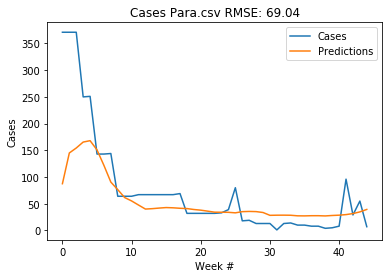

In [9]:
for i in range(10):
    os.mkdir("Experiments/{}".format(i))
    #Splits the files into 7-Train 3-Test
    dataFolder = "../../../data/Brazil/processed_data/stateFiles"
    files = os.listdir(dataFolder)
    train_files = random.sample(files, 7)
    test_files = list(filter(lambda x: x not in train_files, files))
    model = loadOrCreateModel("Model{}".format(i))
    
    for file in train_files:
        x,y = getXY("{}/{}".format(dataFolder, file), population[file])
        model.fit(x, y,
                 epochs = 10,
                 batch_size=x.shape[0],
                 verbose=1, 
                 shuffle=False)

    #Evaluate model
    for file in test_files:
        x, y = getXY("{}/{}".format(dataFolder, file), population[file])
        predictions = model.predict(x)
        y = y.reshape((len(y), 1))

        inv_yPred = np.apply_along_axis(lambda x: x * population[file] / 100000, 1, predictions)
        inv_y = np.apply_along_axis(lambda x: x * population[file] / 100000, 1, y)

        rmse = sqrt(mean_squared_error(inv_y, inv_yPred))

        print('Test RMSE: %.3f' % rmse)
        print("Total", sum(inv_y))
        print("len", len(inv_y))
        pyplot.clf()
        pyplot.title("Cases {} RMSE: {:.2f}".format(file, rmse))
        pyplot.ylabel("Cases")
        pyplot.xlabel("Week #")
        pyplot.plot(inv_y, label="Cases")
        pyplot.plot(inv_yPred, label="Predictions")
        pyplot.legend()
        pngName = file.split(".")[0]
        pyplot.savefig('Experiments/{}/{}.png'.format(i, pngName))
        
        saveModel(model, "Experiments/{0}/model-{0}".format(i))
        ExportPredictions(model, "Experiments/{}".format(i), test_files)
    